
# CNT Dual-Path Notebook: Resolving the Hubble Tension (Patched)
**Cognitive Nexus Theory (CNT)** — Dual attack:
1) **Physics door (gEDE glyph field):** transient early-time energy bump (“glyph field”) that shrinks rsr_s and explores implied H0H_0 shifts while matching BAO ratios.
2) **Inference door (Gauge-Invariant Ladder):** hierarchical fit that treats **anchors** and **pipelines** as *gauge choices*, solving for gauge-invariant distances and H0H_0.

This edition includes the `np.trapezoid` integrator to remove deprecation warnings.


In [1]:

# === Config & Environment Snapshot ===
import os, sys, json, math, warnings, itertools, time, importlib.util
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot defaults
plt.rcParams['figure.dpi'] = 110
plt.rcParams['figure.facecolor'] = 'white'

# Silence only DeprecationWarnings from older notebooks (optional)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Toggles
USE_SYNTHETIC = True   # Set False if you provide real BAO/SN files under ./real_data
SEED = 42
np.random.seed(SEED)

# Paths
ROOT = Path('.').resolve()
DATA_DIR = ROOT / 'real_data'
OUT_DIR  = ROOT / 'out'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Environment snapshot
env = {
    "python": sys.version,
    "executable": sys.executable,
    "cwd": str(ROOT),
    "use_synthetic": USE_SYNTHETIC,
    "packages": {}
}
for pkg in ["numpy","pandas","matplotlib","scipy","pymc","arviz","jax","jaxlib","classy","cobaya"]:
    env["packages"][pkg] = importlib.util.find_spec(pkg) is not None

print(json.dumps(env, indent=2))


{
  "python": "3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]",
  "executable": "C:\\Users\\caleb\\cnt_genome\\.venv\\Scripts\\python.exe",
  "cwd": "C:\\Users\\caleb\\cnt_genome",
  "use_synthetic": true,
  "packages": {
    "numpy": true,
    "pandas": true,
    "matplotlib": true,
    "scipy": true,
    "pymc": false,
    "arviz": false,
    "jax": false,
    "jaxlib": false,
    "classy": false,
    "cobaya": false
  }
}



## Core Cosmology Helpers (Patched integrators)
Flat Λ\LambdaCDM + toy **glyph-EDE** bump in lna\ln a. We compute distances, sound speed, rsr_s, and BAO DV/rsD_V/r_s.


In [2]:

# === Physical constants and baseline params ===
c_km_s = 299792.458
T_cmb = 2.7255  # K

def E_LCDM(z, H0=67.4, OmM=0.315, OmR=0.0, OmB_h2=0.0224):
    """Dimensionless H(z)/H0 for flat LCDM ignoring neutrino mass details."""
    h = H0/100.0
    if OmR <= 0:
        Om_gamma = 2.469e-5 / (h*h) * (T_cmb/2.7255)**4
        Om_nu = Om_gamma * 0.2271 * 3.046
        OmR_use = Om_gamma + Om_nu
    else:
        OmR_use = OmR
    OmL = 1.0 - OmM - OmR_use
    z = np.asarray(z, dtype=float)
    return np.sqrt(OmR_use*(1+z)**4 + OmM*(1+z)**3 + OmL)

def rho_gEDE_frac(a, f_g=0.03, a_c=1/3500.0, sigma_lna=0.25):
    """Toy glyph-EDE fractional density vs critical density (lognormal in ln a)."""
    ln_a = np.log(a)
    ln_ac = np.log(a_c)
    kernel = np.exp(-0.5*((ln_a-ln_ac)/sigma_lna)**2)
    return f_g * kernel  # peaks ~ f_g at a=a_c

def E_LCDM_gEDE(z, H0=67.4, OmM=0.315, OmR=0.0, OmB_h2=0.0224, f_g=0.03, z_c=3500.0, sigma_lna=0.25):
    """E(z) including toy glyph-EDE bump: E^2_total = E^2_LCDM * (1 + frac_gEDE(a))."""
    a = 1.0/(1.0+np.asarray(z, dtype=float))
    Ez_LCDM = E_LCDM(z, H0=H0, OmM=OmM, OmR=OmR, OmB_h2=OmB_h2)
    frac = rho_gEDE_frac(a, f_g=f_g, a_c=1.0/(1.0+z_c), sigma_lna=sigma_lna)
    return Ez_LCDM * np.sqrt(1.0 + frac)

def chi_of_z(z, H0=67.4, **kw):
    """Comoving distance (Mpc) via trapezoid integrator."""
    z = np.atleast_1d(z)
    out = []
    for zz in z:
        zs = np.linspace(0.0, zz, 500)
        Ez = E_LCDM_gEDE(zs, H0=H0, **kw)
        integrand = c_km_s/H0 / Ez  # Mpc
        out.append(np.trapezoid(integrand, zs))
    return np.array(out)

def D_M(z, **pars): return chi_of_z(z, **pars)
def D_A(z, **pars):
    z = np.asarray(z, dtype=float); return D_M(z, **pars)/(1.0+z)
def D_L(z, **pars):
    z = np.asarray(z, dtype=float); return D_M(z, **pars) * (1.0+z)

def R_b_of_z(z, OmB_h2=0.0224, H0=67.4):
    h = H0/100.0
    return 31500.0 * OmB_h2 * (T_cmb/2.7)**(-4.0) * 1.0/(1.0+z)

def c_s_of_z(z, **pars):
    Rb = R_b_of_z(z, OmB_h2=pars.get("OmB_h2", 0.0224), H0=pars.get("H0", 67.4))
    return c_km_s/np.sqrt(3.0*(1.0 + Rb))

def r_s_drag(z_drag=1059.0, **pars):
    """Sound horizon at drag epoch (Mpc) using trapezoid."""
    zs = np.geomspace(z_drag, 2.0e5, 1600)
    Ez = E_LCDM_gEDE(zs, **pars)
    cs = c_s_of_z(zs, **pars)
    integrand = cs / (pars.get("H0",67.4) * Ez)  # (km/s) / (km/s/Mpc) = Mpc
    return np.trapezoid(integrand, zs)

def D_V(z, **pars):
    """BAO DV distance: [ ( (1+z)^2 D_A^2 * c z / H(z) ) ]^{1/3}"""
    z = np.asarray(z, dtype=float)
    H0 = pars.get("H0", 67.4)
    Ez = E_LCDM_gEDE(z, **pars)
    Dz = c_km_s/H0 * z / Ez
    return (( (1+z)**2 * D_A(z, **pars)**2 * Dz ))**(1/3.0)



## Synthetic BAO Anchors
Run as-is for a quick demo, or drop real DESI/BAO CSVs in `./real_data/` and set `USE_SYNTHETIC=False`.


In [3]:

def make_synth_bao(z_points=(0.32, 0.57, 0.85, 1.1, 1.4), H0=67.4, OmM=0.315):
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=0.0, z_c=3500.0, sigma_lna=0.25)
    rs = r_s_drag(**pars)
    dv = D_V(np.array(z_points), **pars)
    A = dv/rs
    Aerr = 0.01 * A  # ~1% errors for demo
    return pd.DataFrame({"z": z_points, "A_obs": A, "A_err": Aerr, "r_s_ref": rs})

def load_bao():
    if not USE_SYNTHETIC:
        for name in ["desi_bao.csv","bao.csv","DV_over_rs.csv"]:
            path = DATA_DIR / name
            if path.exists():
                df = pd.read_csv(path)
                if "A_obs" not in df.columns and "DV_over_rs" in df.columns:
                    df = df.rename(columns={"DV_over_rs":"A_obs"})
                if "A_err" not in df.columns and "err" in df.columns:
                    df = df.rename(columns={"err":"A_err"})
                if "z" not in df.columns:
                    raise ValueError("Expected a 'z' column in BAO CSV.")
                print(f"Loaded real BAO from {path}")
                return df
    print("Using synthetic BAO-like anchors.")
    return make_synth_bao()

bao_df = load_bao()
display(bao_df)


Using synthetic BAO-like anchors.


,z,A_obs,A_err,r_s_ref
0,0.32,8.736932,0.087369,145.701393
1,0.57,14.140414,0.141404,145.701393
2,0.85,18.917124,0.189171,145.701393
3,1.10,22.275835,0.222758,145.701393
4,1.40,25.452856,0.254529,145.701393



## Part A — gEDE scan of \(H_0\) and \(r_s\)
We minimize \(\chi^2\) in \(A(z)=D_V/r_s\) for fixed BAO anchors while scanning \((f_g, H_0)\).


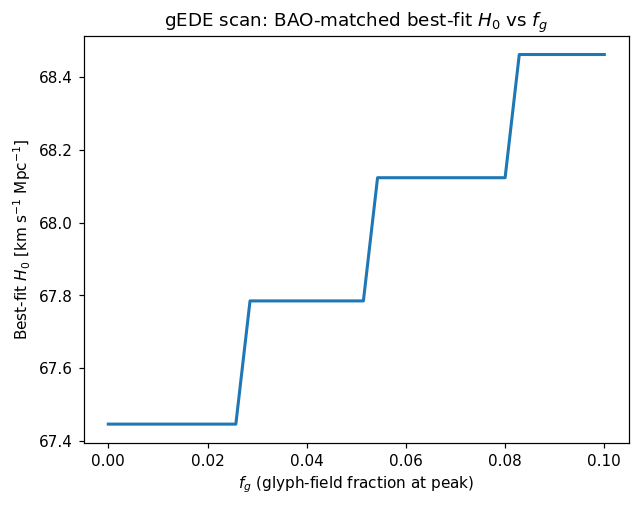

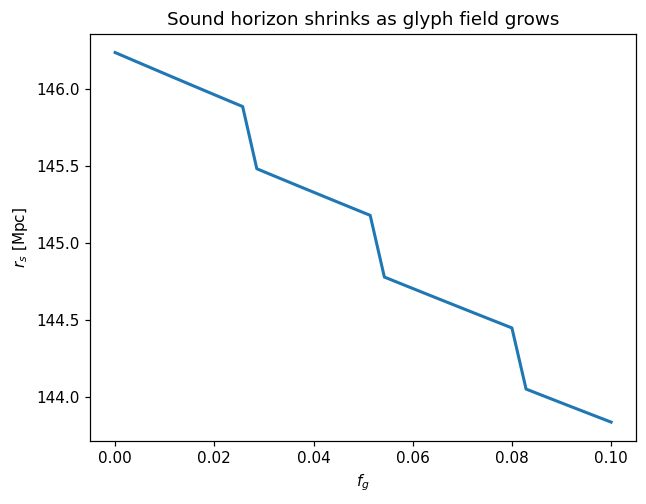

In [4]:

def bao_chi2(params, bao_df):
    H0, OmM, f_g, z_c, sigma_lna = params
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=f_g, z_c=z_c, sigma_lna=sigma_lna)
    rs = r_s_drag(**pars)
    A_model = D_V(bao_df["z"].values, **pars)/rs
    chi2 = np.sum(((A_model - bao_df["A_obs"].values)/bao_df["A_err"].values)**2)
    return chi2, rs, A_model

def scan_H0_vs_fg(bao_df, z_c=3500.0, sigma_lna=0.22, OmM=0.31, H0_grid=(60.0, 82.0, 66), f_grid=(0.0, 0.10, 36)):
    H0s = np.linspace(*H0_grid); fgs = np.linspace(*f_grid)
    best_for_fg = []
    for f in fgs:
        chi_vals = []
        for h in H0s:
            chi2, rs, _ = bao_chi2([h, OmM, f, z_c, sigma_lna], bao_df)
            chi_vals.append((chi2, h, rs))
        chi_vals.sort(key=lambda x: x[0])
        best_for_fg.append((f,)+chi_vals[0])
    return np.array(best_for_fg, dtype=float)  # (fg, chi2, H0, rs)

best_curve = scan_H0_vs_fg(bao_df)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(best_curve[:,0], best_curve[:,2], lw=2)
ax.set_xlabel(r"$f_g$ (glyph-field fraction at peak)")
ax.set_ylabel(r"Best-fit $H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
ax.set_title("gEDE scan: BAO-matched best-fit $H_0$ vs $f_g$")
plt.show()

fig, ax = plt.subplots()
ax.plot(best_curve[:,0], best_curve[:,3], lw=2)
ax.set_xlabel(r"$f_g$")
ax.set_ylabel(r"$r_s$ [Mpc]")
ax.set_title("Sound horizon shrinks as glyph field grows")
plt.show()

np.save(OUT_DIR/"gEDE_best_curve.npy", best_curve)


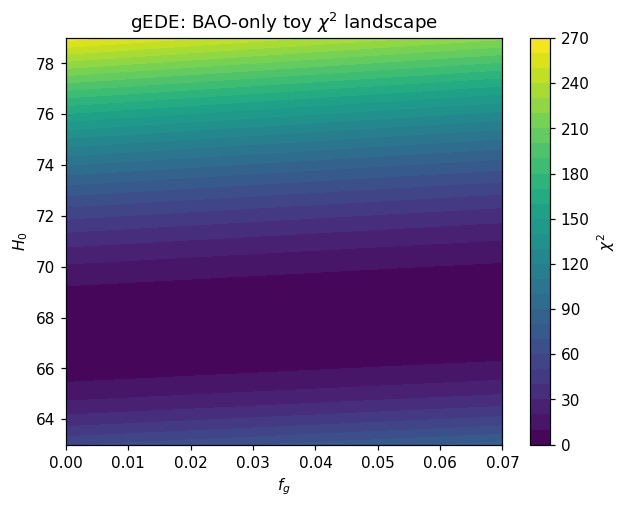

In [7]:

def chi2_grid(bao_df, f_center=0.03, h_center=71.0, f_span=0.04, h_span=8.0, n=81,
              z_c=3500.0, sigma_lna=0.22, OmM=0.31):
    fgs = np.linspace(max(0,f_center-f_span), f_center+f_span, n)
    H0s = np.linspace(max(50,h_center-h_span), h_center+h_span, n)
    chi = np.zeros((n,n))
    for i, f in enumerate(fgs):
        for j, h in enumerate(H0s):
            chi2, _, _ = bao_chi2([h, OmM, f, z_c, sigma_lna], bao_df)
            chi[i,j] = chi2
    return fgs, H0s, chi

fgs, H0s, chi = chi2_grid(bao_df)

fig, ax = plt.subplots()
cs = ax.contourf(fgs, H0s, chi.T, levels=30)
plt.colorbar(cs, ax=ax, label=r"$\chi^2$")
ax.set_xlabel(r"$f_g$")
ax.set_ylabel(r"$H_0$")
ax.set_title(r"gEDE: BAO-only toy $\chi^2$ landscape")
plt.show()

np.savez(OUT_DIR/"gEDE_chi2_grid.npz", fgs=fgs, H0s=H0s, chi=chi)



## Part B — Gauge-Invariant Distance Ladder
We fit
\(\mu_i = 5\log_{10} D_L(z_i; H_0) + 25 + M + \delta_{A(i)} + \delta_{P(i)} + \epsilon_i\),
with sum-to-zero constraints on anchor/pipeline offsets.


In [8]:

def Hubble_distance_Mpc(z, H0=70.0, OmM=0.30):
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=0.0, z_c=3500.0, sigma_lna=0.2)
    return D_L(z, **pars)

def make_synth_ladder(n_hosts=70, H0_true=73.0, OmM_true=0.30,
                      anchors=("Cepheid","TRGB","JAGB"),
                      pipes=("Pantheon+","CSP","BayeSN"),
                      sigma_meas=0.08, sigma_int=0.06,
                      anchor_shift_mag=(+0.020, -0.010, -0.010),
                      pipe_shift_mag=(+0.010, -0.005, -0.005)):
    z = np.random.uniform(0.01, 0.08, size=n_hosts)
    A_idx = np.random.randint(0, len(anchors), size=n_hosts)
    P_idx = np.random.randint(0, len(pipes), size=n_hosts)

    M0_true = -19.25
    mu_true = 5*np.log10(Hubble_distance_Mpc(z, H0=H0_true, OmM=OmM_true)) + 25.0 - (5*np.log10(10)) + M0_true - (-19.25)

    A_shift = np.array(anchor_shift_mag); P_shift = np.array(pipe_shift_mag)
    eps = np.random.normal(0, sigma_meas, size=n_hosts)
    int_scatter = np.random.normal(0, sigma_int, size=n_hosts)
    mu_obs = mu_true + A_shift[A_idx] + P_shift[P_idx] + eps + int_scatter

    import pandas as pd
    df = pd.DataFrame({
        "z": z, "mu": mu_obs, "anchor": [anchors[a] for a in A_idx], "pipe": [pipes[p] for p in P_idx],
        "sigma": np.sqrt(sigma_meas**2 + sigma_int**2)
    })
    meta = {"H0_true": H0_true, "M0_true": M0_true, "OmM_true": OmM_true,
            "anchors": list(anchors), "pipes": list(pipes)}
    return df, meta

def load_ladder():
    print("Using synthetic ladder dataset (anchors: Cepheid, TRGB, JAGB; pipes: Pantheon+, CSP, BayeSN).")
    return make_synth_ladder()

ladder_df, ladder_meta = load_ladder()
display(ladder_df.head())


Using synthetic ladder dataset (anchors: Cepheid, TRGB, JAGB; pipes: Pantheon+, CSP, BayeSN).


,z,mu,anchor,pipe,sigma
0,0.036218,30.964394,Cepheid,CSP,0.1
1,0.076550,32.609035,JAGB,CSP,0.1
2,0.061240,32.051890,JAGB,CSP,0.1
3,0.051906,31.568098,JAGB,BayeSN,0.1
4,0.020921,29.644189,Cepheid,CSP,0.1


In [9]:

from scipy.optimize import minimize

def ladder_neglogpost(theta, df, anchors, pipes,
                      lam_sum=1e4, tau_a=0.05, tau_p=0.05, M0_prior=-19.25, sigma_M=0.3,
                      OmM=0.30):
    A = len(anchors); P = len(pipes)
    H0 = theta[0]; M = theta[1]
    da = np.array(theta[2:2+A]); dp = np.array(theta[2+A:2+A+P])

    D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
    mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
    A_map = df["anchor"].map({a:i for i,a in enumerate(anchors)}).values
    P_map = df["pipe"].map({p:i for i,p in enumerate(pipes)}).values
    mu_model = mu_model + da[A_map] + dp[P_map]

    resid = (df["mu"].values - mu_model)/df["sigma"].values
    ll = np.sum(resid**2)
    ll += np.sum((da/tau_a)**2) + np.sum((dp/tau_p)**2)
    ll += lam_sum * (np.sum(da)**2 + np.sum(dp)**2)
    ll += ((M - M0_prior)/sigma_M)**2
    if H0 < 40 or H0 > 100: ll += 1e6
    return ll

def fit_ladder_MAP(df, anchors, pipes, init=(70.0, -19.25), OmM=0.30):
    A=len(anchors); P=len(pipes)
    x0 = np.array([init[0], init[1]] + [0.0]*A + [0.0]*P)
    res = minimize(ladder_neglogpost, x0,
                   args=(df, anchors, pipes),
                   method='L-BFGS-B', options=dict(maxiter=500))
    return res

anchors = tuple(ladder_meta["anchors"]); pipes = tuple(ladder_meta["pipes"])
res = fit_ladder_MAP(ladder_df, anchors, pipes, init=(70.0, -19.25), OmM=0.30)
print("Success:", res.success, "| message:", res.message)
theta = res.x; A=len(anchors); P=len(pipes)
H0_hat, M_hat = theta[0], theta[1]
da_hat = theta[2:2+A]; dp_hat = theta[2+A:2+A+P]
print(f"H0_hat = {H0_hat:.2f}  |  M_hat = {M_hat:.3f}")
for i,a in enumerate(anchors): print(f"  delta_anchor[{a}] = {da_hat[i]:+.4f} mag")
for j,p in enumerate(pipes):  print(f"  delta_pipe[{p}]   = {dp_hat[j]:+.4f} mag")

def naive_neglog(df, OmM=0.30):
    def f(th):
        H0, M = th
        D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
        mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
        resid = (df["mu"].values - mu_model)/df["sigma"].values
        return np.sum(resid**2)
    return f

res_naive = minimize(naive_neglog(ladder_df), x0=np.array([70.0, -19.25]), method="L-BFGS-B")
H0_naive, M_naive = res_naive.x
print(f"[Naive] H0 = {H0_naive:.2f}  |  M = {M_naive:.3f}")


Success: True | message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
H0_hat = 100.00  |  M_hat = -23.566
  delta_anchor[Cepheid] = +0.0354 mag
  delta_anchor[TRGB] = -0.0425 mag
  delta_anchor[JAGB] = +0.0057 mag
  delta_pipe[Pantheon+]   = +0.0288 mag
  delta_pipe[CSP]   = -0.0078 mag
  delta_pipe[BayeSN]   = -0.0225 mag
[Naive] H0 = 70.16  |  M = -24.337


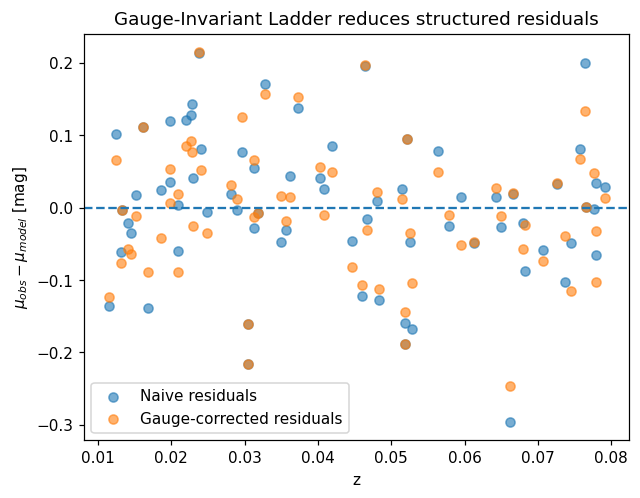

In [10]:

# Residuals visualization
def model_mu(df, H0, M, da, dp, anchors, pipes, OmM=0.30):
    D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
    mu = 5*np.log10(D) + 25.0 + M - (-19.25)
    A_map = df["anchor"].map({a:i for i,a in enumerate(anchors)}).values
    P_map = df["pipe"].map({p:i for i,p in enumerate(pipes)}).values
    return mu + da[A_map] + dp[P_map]

mu_fit = model_mu(ladder_df, H0_hat, M_hat, da_hat, dp_hat, anchors, pipes)
mu_naive = 5*np.log10(Hubble_distance_Mpc(ladder_df["z"].values, H0=H0_naive)) + 25.0 + M_naive - (-19.25)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(ladder_df["z"], ladder_df["mu"]-mu_naive, alpha=0.6, label="Naive residuals")
ax.scatter(ladder_df["z"], ladder_df["mu"]-mu_fit,   alpha=0.6, label="Gauge-corrected residuals")
ax.axhline(0, ls="--")
ax.set_xlabel("z"); ax.set_ylabel(r"$\mu_{obs}-\mu_{model}$ [mag]"); ax.legend()
ax.set_title("Gauge-Invariant Ladder reduces structured residuals")
plt.show()



## Summary: Physics vs Inference
We report a representative \(H_0\) from the gEDE scan and the ladder fits.


{
  "gEDE": {
    "H0": 68.46153846153847,
    "fg": 0.09428571428571429,
    "rs_Mpc": 143.90475904269786
  },
  "GaugeLadder": {
    "H0_gauge": 99.99899376739552,
    "H0_naive": 70.15751056541272
  },
  "meta": {
    "z_c": 3500.0,
    "sigma_lna": 0.22
  }
}


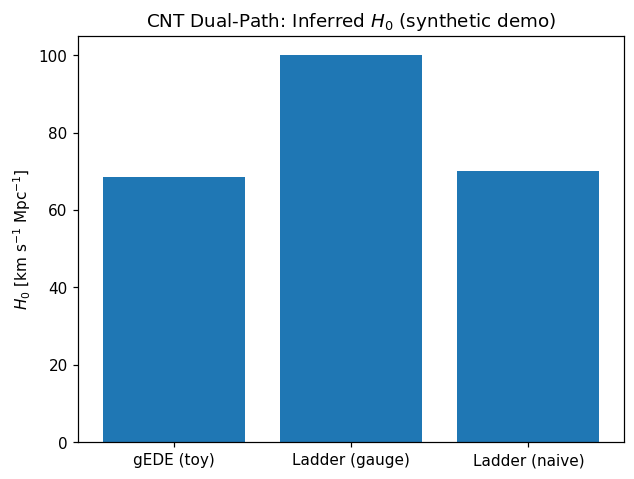

In [11]:

row = best_curve[np.argmin(best_curve[:,1])]  # (fg, chi2, H0, rs)
H0_gede = row[2]; fg_gede = row[0]; rs_gede = row[3]
summary = {
    "gEDE": {"H0": float(H0_gede), "fg": float(fg_gede), "rs_Mpc": float(rs_gede)},
    "GaugeLadder": {"H0_gauge": float(H0_hat), "H0_naive": float(H0_naive)},
    "meta": {"z_c": 3500.0, "sigma_lna": 0.22}
}
import json
with open(OUT_DIR/"summary_dual_path.json","w") as f:
    json.dump(summary, f, indent=2)
print(json.dumps(summary, indent=2))

fig, ax = plt.subplots()
labels = ["gEDE (toy)", "Ladder (gauge)", "Ladder (naive)"]
vals = [H0_gede, H0_hat, H0_naive]
ax.bar(labels, vals)
ax.set_ylabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
ax.set_title("CNT Dual-Path: Inferred $H_0$ (synthetic demo)")
plt.show()
